In [31]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from datasets import load_dataset
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torchsummary import summary

In [28]:
class CIFAR10Dataset(Dataset):
    """Custom PyTorch Dataset for CIFAR-10"""
    
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.targets[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

def prepare_cifar10_dataset(batch_size=64):
    # Load CIFAR-10 dataset from Hugging Face
    print("Loading CIFAR-10 dataset from Hugging Face...")
    dataset = load_dataset("cifar10")
    
    # Extract train and test sets
    train_dataset = dataset['train']
    test_dataset = dataset['test']
    
    # Convert to numpy arrays
    X_train = np.array([np.array(image) for image in train_dataset['img']])
    y_train = np.array(train_dataset['label'])
    
    X_test = np.array([np.array(image) for image in test_dataset['img']])
    y_test = np.array(test_dataset['label'])
    
    # Print dataset information
    print(f"Original dataset shapes:")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
    
    # Define transformations
    train_transform = transforms.Compose([
        transforms.ToTensor(),  # Converts to tensor and normalizes to [0, 1]
    ])
    
    test_transform = transforms.Compose([
        transforms.ToTensor(),  # Converts to tensor and normalizes to [0, 1]
    ])
    
    # Create custom datasets
    train_data = CIFAR10Dataset(X_train, y_train, transform=train_transform)
    test_data = CIFAR10Dataset(X_test, y_test, transform=test_transform)
    
    # Split training data into train and validation sets (80% train, 20% validation)
    train_size = int(0.8 * len(train_data))
    val_size = len(train_data) - train_size
    train_dataset, val_dataset = random_split(train_data, [train_size, val_size], 
                                             generator=torch.Generator().manual_seed(42))
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_data, batch_size=batch_size)
    
    # Print dataset sizes
    print("\nAfter splitting:")
    print(f"Training set: {len(train_dataset)} images")
    print(f"Validation set: {len(val_dataset)} images")
    print(f"Test set: {len(test_data)} images")
    
    # Define class names for reference
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                  'dog', 'frog', 'horse', 'ship', 'truck']
    
    # Visualize some sample images
    def show_samples(dataloader, num_samples=5):
        # Get a batch of images
        images, labels = next(iter(dataloader))
        
        # Convert tensors to numpy arrays for plotting
        images = images.numpy()
        
        # Plot images
        plt.figure(figsize=(12, 3))
        for i in range(num_samples):
            # Transpose from (C, H, W) to (H, W, C) for plotting
            plt.subplot(1, num_samples, i+1)
            plt.imshow(np.transpose(images[i], (1, 2, 0)))
            plt.title(class_names[labels[i]])
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    #print("\nDisplaying sample images from the training set:")
    #show_samples(train_loader)
    
    return train_loader, val_loader, test_loader, class_names

Loading CIFAR-10 dataset from Hugging Face...


Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 156734.89 examples/s]


Original dataset shapes:
X_train: (50000, 32, 32, 3), y_train: (50000,)
X_test: (10000, 32, 32, 3), y_test: (10000,)

After splitting:
Training set: 40000 images
Validation set: 10000 images
Test set: 10000 images

Displaying sample images from the training set:


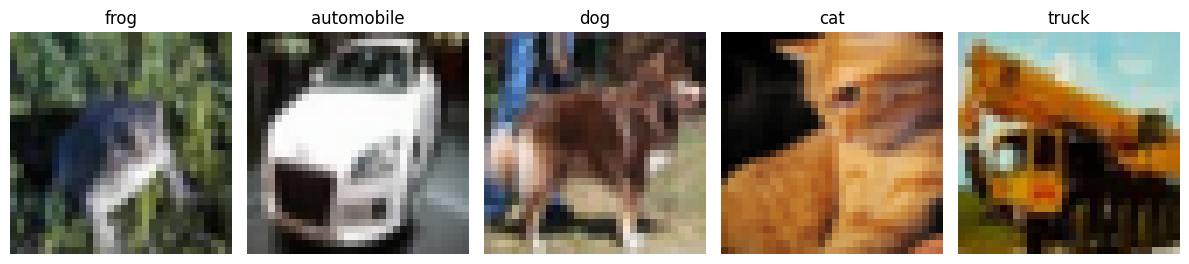

In [5]:
train_loader, val_loader, test_loader, class_names = prepare_cifar10_dataset()
    
sample_batch, sample_labels = next(iter(train_loader))

In [ ]:
print("\nDataLoader Information:")
print(f"Batch shape: {sample_batch.shape}")
print(f"Labels shape: {sample_labels.shape}")
print(f"Data type: {sample_batch.dtype}")
print(f"Min value: {torch.min(sample_batch)}, Max value: {torch.max(sample_batch)}")


DataLoader Information:
Batch shape: torch.Size([64, 3, 32, 32])
Labels shape: torch.Size([64])
Data type: torch.float32
Min value: 0.0, Max value: 1.0


In [18]:
import math

class CIFAR10CNN(nn.Module):
    def __init__(self, num_filters=32, num_conv_layers=3, dropout_rate=0.3):
        super(CIFAR10CNN, self).__init__()
        self.num_conv_layers = num_conv_layers
        
        # First convolutional block
        self.conv_layers = nn.ModuleList()
        self.conv_layers.append(nn.Conv2d(3, num_filters, kernel_size=3, padding=1))
        self.batch_norms = nn.ModuleList()
        self.batch_norms.append(nn.BatchNorm2d(num_filters))
        
        # Additional convolutional blocks
        for i in range(1, num_conv_layers):
            in_channels = num_filters * (2**(i-1))
            out_channels = num_filters * (2**i)
            self.conv_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            self.batch_norms.append(nn.BatchNorm2d(out_channels))
        
        # Calculate final feature map size after conv layers with pooling (using ceil to avoid 0)
        final_size = math.ceil(32 / (2**num_conv_layers))
        final_channels = num_filters * (2**(num_conv_layers-1))
        
        # Fully connected layers
        self.fc1 = nn.Linear(final_channels * final_size * final_size, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        # Apply convolutional layers
        for i in range(self.num_conv_layers):
            x = self.conv_layers[i](x)
            x = self.batch_norms[i](x)
            x = F.relu(x)
            # Use ceil_mode=True to prevent spatial dimensions from shrinking to 0
            x = F.max_pool2d(x, 2, ceil_mode=True)
        
        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)
        
        # Apply fully connected layers
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.bn_fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)


In [19]:
# Training function
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Calculate running statistics
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correct / total
    
    return train_loss, train_accuracy

# Validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # Calculate loss
            loss = criterion(output, target)
            val_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100. * correct / total
    
    return val_loss, val_accuracy

# Test function
def test(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            
            # Class-wise accuracy
            c = (predicted == target).squeeze()
            for i in range(len(target)):
                label = target[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    accuracy = 100. * correct / total
    
    class_accuracies = {}
    for i in range(10):
        if class_total[i] > 0:
            class_accuracies[i] = 100 * class_correct[i] / class_total[i]
    
    return accuracy, class_accuracies


In [20]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.verbose = verbose
        
    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.best_score:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), 'checkpoint.pt')

In [21]:
def plot_training_history(history, title):
    plt.figure(figsize=(12, 4))
    
    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot training & validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [22]:
def train_model(model, train_loader, val_loader, test_loader, learning_rate=0.001, epochs=50, device='cuda'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)
    early_stopping = EarlyStopping(patience=10, verbose=True)
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    best_val_acc = 0
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        # Train
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        
        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        # Update learning rate scheduler
        scheduler.step(val_loss)
        
        # Print epoch results
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        # Track best validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
        
        # Check early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
    
    return history, best_val_acc

In [23]:
def plot_comparative_results(results):
    # Group experiments by type
    experiment_types = {
        'Learning Rate': [r for r in results if r['name'].startswith('LR=')],
        'Batch Size': [r for r in results if r['name'].startswith('Batch=')],
        'Number of Filters': [r for r in results if r['name'].startswith('Filters=')],
        'Number of Layers': [r for r in results if r['name'].startswith('Layers=')]
    }
    
    # Plot accuracy comparison
    plt.figure(figsize=(15, 10))
    
    for i, (exp_type, exps) in enumerate(experiment_types.items()):
        plt.subplot(2, 2, i+1)
        
        names = [exp['name'] for exp in exps]
        test_accs = [exp['test_accuracy'] for exp in exps]
        val_accs = [exp['best_val_accuracy'] for exp in exps]
        
        x = range(len(names))
        width = 0.35
        
        plt.bar([p - width/2 for p in x], val_accs, width, label='Validation')
        plt.bar([p + width/2 for p in x], test_accs, width, label='Test')
        
        plt.xlabel('Experiment')
        plt.ylabel('Accuracy (%)')
        plt.title(f'Accuracy by {exp_type}')
        plt.xticks(x, names)
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Plot training time comparison
    plt.figure(figsize=(15, 10))
    
    for i, (exp_type, exps) in enumerate(experiment_types.items()):
        plt.subplot(2, 2, i+1)
        
        names = [exp['name'] for exp in exps]
        times = [exp['training_time'] for exp in exps]
        
        plt.bar(names, times)
        plt.xlabel('Experiment')
        plt.ylabel('Training Time (seconds)')
        plt.title(f'Training Time by {exp_type}')
    
    plt.tight_layout()
    plt.show()

In [32]:
def evaluate_model(model, test_loader, device):
    """
    Evaluate the model on the test set and compute Accuracy, Precision,
    Recall, F1-Score, and Confusion Matrix.
    """
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds = output.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='weighted')
    recall = recall_score(all_targets, all_preds, average='weighted')
    f1 = f1_score(all_targets, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_targets, all_preds)
    
    return accuracy, precision, recall, f1, conf_matrix

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [25]:
experiments = []

In [33]:
experiments = []
learning_rates = [0.001, 0.01, 0.1]

for lr in learning_rates:
    experiment_name = f"LR={lr}"
    print(f"\nRunning experiment: {experiment_name}")
    
    # Use default batch size, filters, and layers for this experiment
    train_loader, val_loader, test_loader, class_names = prepare_cifar10_dataset(batch_size=64)
    model = CIFAR10CNN(num_filters=32, num_conv_layers=3, dropout_rate=0.3).to(device)
    
    start_time = time.time()
    history, best_val_acc = train_model(model, train_loader, val_loader, test_loader,
                                        learning_rate=lr, epochs=50, device=device)
    training_time = time.time() - start_time
    
    # Get test accuracy from the existing test() function (if needed)
    test_acc, _ = test(model, test_loader, device)
    
    # Compute additional metrics on the test set
    acc, precision, recall, f1, conf_matrix = evaluate_model(model, test_loader, device)
    
    experiments.append({
        "name": experiment_name,
        "best_val_accuracy": best_val_acc,
        "test_accuracy": test_acc,
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "confusion_matrix": conf_matrix,
        "training_time": training_time
    })
    
    # Optionally print the metrics for this experiment
    print(f"Test Accuracy: {acc*100:.2f}%")
    print(f"Precision: {precision*100:.2f}%")
    print(f"Recall: {recall*100:.2f}%")
    print(f"F1-Score: {f1*100:.2f}%")
    print("Confusion Matrix:")
    print(conf_matrix)



Running experiment: LR=0.001
Loading CIFAR-10 dataset from Hugging Face...
Original dataset shapes:
X_train: (50000, 32, 32, 3), y_train: (50000,)
X_test: (10000, 32, 32, 3), y_test: (10000,)

After splitting:
Training set: 40000 images
Validation set: 10000 images
Test set: 10000 images

Epoch 1/50


/home/hashim/miniconda3/envs/gena1/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Loss: 1.1982, Train Acc: 57.39%, Val Loss: 1.1255, Val Acc: 60.51%
Validation loss decreased (1.125455 --> 1.125455). Saving model...

Epoch 2/50
Train Loss: 0.8589, Train Acc: 69.69%, Val Loss: 0.9201, Val Acc: 67.81%
Validation loss decreased (0.920065 --> 0.920065). Saving model...

Epoch 3/50
Train Loss: 0.7121, Train Acc: 74.96%, Val Loss: 0.7791, Val Acc: 72.70%
Validation loss decreased (0.779094 --> 0.779094). Saving model...

Epoch 4/50
Train Loss: 0.6048, Train Acc: 78.69%, Val Loss: 0.8189, Val Acc: 71.98%
EarlyStopping counter: 1 out of 10

Epoch 5/50
Train Loss: 0.5108, Train Acc: 82.22%, Val Loss: 0.9288, Val Acc: 69.36%
EarlyStopping counter: 2 out of 10

Epoch 6/50
Train Loss: 0.4378, Train Acc: 84.52%, Val Loss: 0.6936, Val Acc: 77.21%
Validation loss decreased (0.693587 --> 0.693587). Saving model...

Epoch 7/50
Train Loss: 0.3593, Train Acc: 87.35%, Val Loss: 0.8227, Val Acc: 73.89%
EarlyStopping counter: 1 out of 10

Epoch 8/50
Train Loss: 0.3037, Train Acc: 8

/home/hashim/miniconda3/envs/gena1/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Loss: 1.3501, Train Acc: 51.63%, Val Loss: 1.0821, Val Acc: 61.78%
Validation loss decreased (1.082059 --> 1.082059). Saving model...

Epoch 2/50
Train Loss: 0.9770, Train Acc: 65.56%, Val Loss: 1.0376, Val Acc: 63.40%
Validation loss decreased (1.037650 --> 1.037650). Saving model...

Epoch 3/50
Train Loss: 0.8138, Train Acc: 71.86%, Val Loss: 0.8988, Val Acc: 69.21%
Validation loss decreased (0.898820 --> 0.898820). Saving model...

Epoch 4/50
Train Loss: 0.6948, Train Acc: 75.94%, Val Loss: 0.9152, Val Acc: 68.91%
EarlyStopping counter: 1 out of 10

Epoch 5/50
Train Loss: 0.6084, Train Acc: 78.67%, Val Loss: 0.6932, Val Acc: 76.31%
Validation loss decreased (0.693211 --> 0.693211). Saving model...

Epoch 6/50
Train Loss: 0.5338, Train Acc: 81.30%, Val Loss: 0.7192, Val Acc: 75.65%
EarlyStopping counter: 1 out of 10

Epoch 7/50
Train Loss: 0.4612, Train Acc: 83.93%, Val Loss: 0.8431, Val Acc: 72.90%
EarlyStopping counter: 2 out of 10

Epoch 8/50
Train Loss: 0.4031, Train Acc: 8

/home/hashim/miniconda3/envs/gena1/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Loss: 1.8628, Train Acc: 31.18%, Val Loss: 1.5800, Val Acc: 41.94%
Validation loss decreased (1.580038 --> 1.580038). Saving model...

Epoch 2/50
Train Loss: 1.5576, Train Acc: 41.74%, Val Loss: 1.5550, Val Acc: 43.24%
Validation loss decreased (1.554964 --> 1.554964). Saving model...

Epoch 3/50
Train Loss: 1.4176, Train Acc: 47.91%, Val Loss: 1.2888, Val Acc: 52.76%
Validation loss decreased (1.288832 --> 1.288832). Saving model...

Epoch 4/50
Train Loss: 1.3392, Train Acc: 51.76%, Val Loss: 1.1001, Val Acc: 61.83%
Validation loss decreased (1.100097 --> 1.100097). Saving model...

Epoch 5/50
Train Loss: 1.2682, Train Acc: 54.44%, Val Loss: 1.0689, Val Acc: 62.33%
Validation loss decreased (1.068915 --> 1.068915). Saving model...

Epoch 6/50
Train Loss: 1.2037, Train Acc: 57.28%, Val Loss: 1.6351, Val Acc: 46.83%
EarlyStopping counter: 1 out of 10

Epoch 7/50
Train Loss: 1.1756, Train Acc: 58.09%, Val Loss: 0.9676, Val Acc: 65.54%
Validation loss decreased (0.967626 --> 0.96762

In [ ]:
batch_sizes = [16, 32, 64]
for bs in batch_sizes:
    experiment_name = f"Batch={bs}"
    print(f"\nRunning experiment: {experiment_name}")
        
    train_loader, val_loader, test_loader, class_names = prepare_cifar10_dataset(batch_size=bs)
    model = CIFAR10CNN(num_filters=32, num_conv_layers=3, dropout_rate=0.3).to(device)
        
    start_time = time.time()
    history, best_val_acc = train_model(model, train_loader, val_loader, test_loader,
                                              learning_rate=0.001, epochs=50, device=device)
    training_time = time.time() - start_time
        
    test_acc, _ = test(model, test_loader, device)
        
    experiments.append({
        "name": experiment_name,
        "best_val_accuracy": best_val_acc,
        "test_accuracy": test_acc,
        "training_time": training_time
    })

In [ ]:
filter_list = [16, 32, 64]
for nf in filter_list:
    experiment_name = f"Filters={nf}"
    print(f"\nRunning experiment: {experiment_name}")
        
    train_loader, val_loader, test_loader, class_names = prepare_cifar10_dataset(batch_size=64)
    model = CIFAR10CNN(num_filters=nf, num_conv_layers=3, dropout_rate=0.3).to(device)
        
    start_time = time.time()
    history, best_val_acc = train_model(model, train_loader, val_loader, test_loader,
                                              learning_rate=0.001, epochs=50, device=device)
    training_time = time.time() - start_time
        
    test_acc, _ = test(model, test_loader, device)
        
    experiments.append({
        "name": experiment_name,
        "best_val_accuracy": best_val_acc,
        "test_accuracy": test_acc,
        "training_time": training_time
    })

In [ ]:
layer_list = [3, 5, 7]
for nl in layer_list:
    experiment_name = f"Layers={nl}"
    print(f"\nRunning experiment: {experiment_name}")
        
    train_loader, val_loader, test_loader, class_names = prepare_cifar10_dataset(batch_size=64)
    model = CIFAR10CNN(num_filters=32, num_conv_layers=nl, dropout_rate=0.3).to(device)
        
    start_time = time.time()
    history, best_val_acc = train_model(model, train_loader, val_loader, test_loader,
                                              learning_rate=0.001, epochs=50, device=device)
    training_time = time.time() - start_time
        
    test_acc, _ = test(model, test_loader, device)
        
    experiments.append({
        "name": experiment_name,
        "best_val_accuracy": best_val_acc,
        "test_accuracy": test_acc,
        "training_time": training_time
    })
    

In [ ]:
plot_comparative_results(experiments)

Using device: cuda

Running experiment: LR=0.001
Loading CIFAR-10 dataset from Hugging Face...
Original dataset shapes:
X_train: (50000, 32, 32, 3), y_train: (50000,)
X_test: (10000, 32, 32, 3), y_test: (10000,)

After splitting:
Training set: 40000 images
Validation set: 10000 images
Test set: 10000 images

Displaying sample images from the training set:


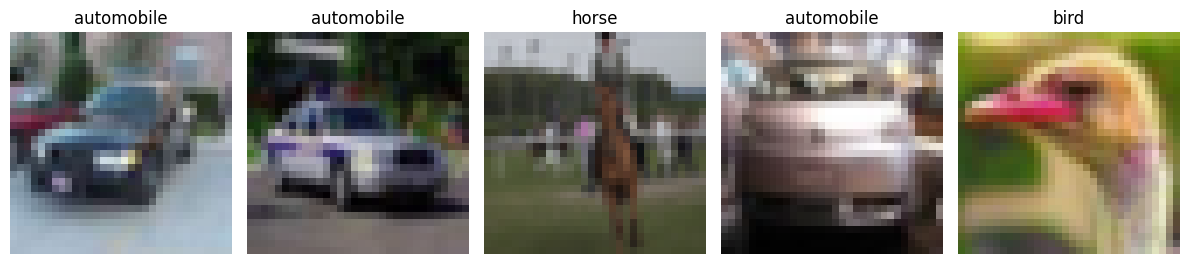


Epoch 1/50
Train Loss: 1.2293, Train Acc: 56.19%, Val Loss: 1.1549, Val Acc: 61.03%
Validation loss decreased (1.154921 --> 1.154921). Saving model...

Epoch 2/50
Train Loss: 0.8623, Train Acc: 69.56%, Val Loss: 0.8073, Val Acc: 72.27%
Validation loss decreased (0.807342 --> 0.807342). Saving model...

Epoch 3/50
Train Loss: 0.7136, Train Acc: 74.89%, Val Loss: 0.7706, Val Acc: 73.40%
Validation loss decreased (0.770620 --> 0.770620). Saving model...

Epoch 4/50
Train Loss: 0.5995, Train Acc: 79.25%, Val Loss: 0.6633, Val Acc: 77.11%
Validation loss decreased (0.663260 --> 0.663260). Saving model...

Epoch 5/50
Train Loss: 0.5113, Train Acc: 81.97%, Val Loss: 0.7002, Val Acc: 75.99%
EarlyStopping counter: 1 out of 10

Epoch 6/50
Train Loss: 0.4262, Train Acc: 85.07%, Val Loss: 0.7443, Val Acc: 75.55%
EarlyStopping counter: 2 out of 10

Epoch 7/50
Train Loss: 0.3579, Train Acc: 87.30%, Val Loss: 0.6764, Val Acc: 78.46%
EarlyStopping counter: 3 out of 10

Epoch 8/50
Train Loss: 0.3019, 

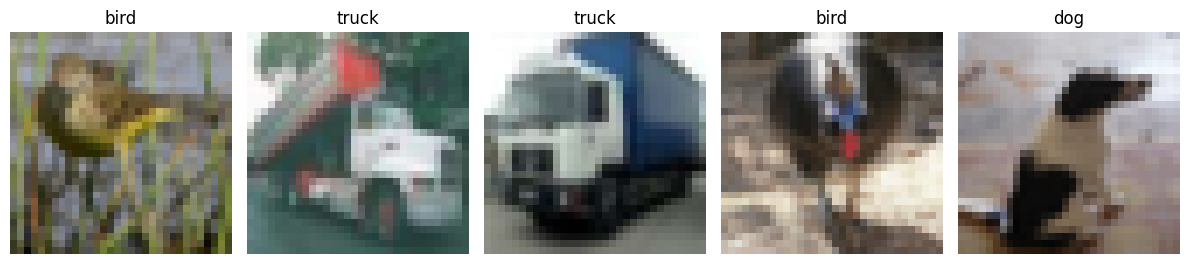


Epoch 1/50
Train Loss: 1.3431, Train Acc: 51.83%, Val Loss: 1.1502, Val Acc: 58.83%
Validation loss decreased (1.150160 --> 1.150160). Saving model...

Epoch 2/50
Train Loss: 0.9648, Train Acc: 66.16%, Val Loss: 0.8546, Val Acc: 69.60%
Validation loss decreased (0.854556 --> 0.854556). Saving model...

Epoch 3/50
Train Loss: 0.8104, Train Acc: 71.89%, Val Loss: 0.9736, Val Acc: 65.61%
EarlyStopping counter: 1 out of 10

Epoch 4/50
Train Loss: 0.6976, Train Acc: 75.67%, Val Loss: 0.8201, Val Acc: 71.58%
Validation loss decreased (0.820105 --> 0.820105). Saving model...

Epoch 5/50
Train Loss: 0.6161, Train Acc: 78.58%, Val Loss: 0.7160, Val Acc: 75.23%
Validation loss decreased (0.715977 --> 0.715977). Saving model...

Epoch 6/50
Train Loss: 0.5384, Train Acc: 81.14%, Val Loss: 0.7548, Val Acc: 74.13%
EarlyStopping counter: 1 out of 10

Epoch 7/50
Train Loss: 0.4706, Train Acc: 83.58%, Val Loss: 0.7445, Val Acc: 75.81%
EarlyStopping counter: 2 out of 10

Epoch 8/50
Train Loss: 0.4062, 

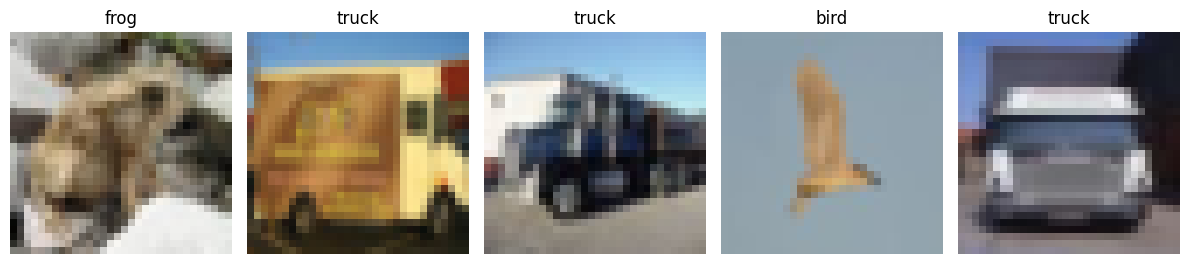


Epoch 1/50
Train Loss: 1.9438, Train Acc: 26.98%, Val Loss: 1.6516, Val Acc: 37.05%
Validation loss decreased (1.651610 --> 1.651610). Saving model...

Epoch 2/50
Train Loss: 1.6767, Train Acc: 36.22%, Val Loss: 1.3926, Val Acc: 49.98%
Validation loss decreased (1.392603 --> 1.392603). Saving model...

Epoch 3/50
Train Loss: 1.5651, Train Acc: 40.60%, Val Loss: 1.4140, Val Acc: 49.79%
EarlyStopping counter: 1 out of 10

Epoch 4/50
Train Loss: 1.4725, Train Acc: 44.96%, Val Loss: 1.2617, Val Acc: 55.88%
Validation loss decreased (1.261695 --> 1.261695). Saving model...

Epoch 5/50
Train Loss: 1.4166, Train Acc: 47.41%, Val Loss: 1.1611, Val Acc: 59.25%
Validation loss decreased (1.161055 --> 1.161055). Saving model...

Epoch 6/50
Train Loss: 1.3509, Train Acc: 49.99%, Val Loss: 1.1856, Val Acc: 58.02%
EarlyStopping counter: 1 out of 10

Epoch 7/50
Train Loss: 1.3072, Train Acc: 51.48%, Val Loss: 1.1019, Val Acc: 61.11%
Validation loss decreased (1.101887 --> 1.101887). Saving model...


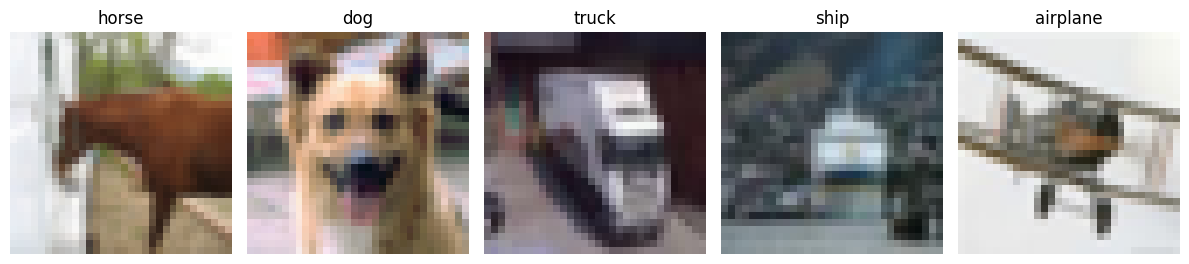


Epoch 1/50
Train Loss: 1.2967, Train Acc: 53.70%, Val Loss: 1.2814, Val Acc: 55.90%
Validation loss decreased (1.281401 --> 1.281401). Saving model...

Epoch 2/50
Train Loss: 0.9579, Train Acc: 66.56%, Val Loss: 0.9998, Val Acc: 64.94%
Validation loss decreased (0.999795 --> 0.999795). Saving model...

Epoch 3/50
Train Loss: 0.8169, Train Acc: 71.77%, Val Loss: 0.7090, Val Acc: 75.35%
Validation loss decreased (0.709019 --> 0.709019). Saving model...

Epoch 4/50
Train Loss: 0.7117, Train Acc: 75.67%, Val Loss: 0.6792, Val Acc: 76.08%
Validation loss decreased (0.679204 --> 0.679204). Saving model...

Epoch 5/50
Train Loss: 0.6225, Train Acc: 78.57%, Val Loss: 0.7146, Val Acc: 75.68%
EarlyStopping counter: 1 out of 10

Epoch 6/50
Train Loss: 0.5504, Train Acc: 80.89%, Val Loss: 0.6454, Val Acc: 77.70%
Validation loss decreased (0.645403 --> 0.645403). Saving model...

Epoch 7/50
Train Loss: 0.4864, Train Acc: 83.22%, Val Loss: 0.6270, Val Acc: 78.78%
Validation loss decreased (0.626976

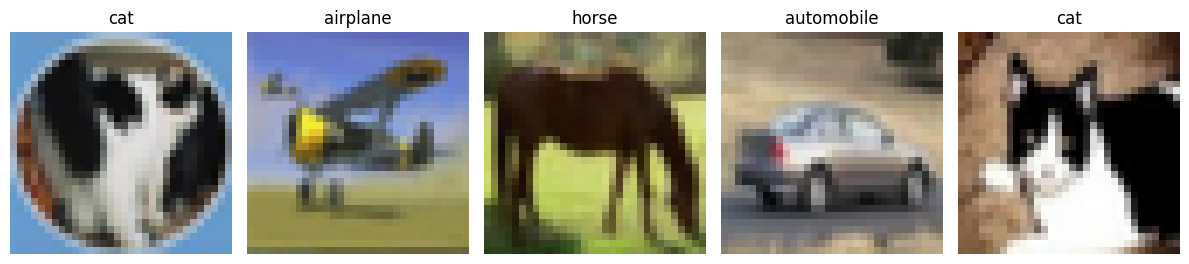


Epoch 1/50
Train Loss: 1.2197, Train Acc: 56.31%, Val Loss: 1.2915, Val Acc: 55.30%
Validation loss decreased (1.291482 --> 1.291482). Saving model...

Epoch 2/50
Train Loss: 0.8801, Train Acc: 69.02%, Val Loss: 1.0378, Val Acc: 65.15%
Validation loss decreased (1.037788 --> 1.037788). Saving model...

Epoch 3/50
Train Loss: 0.7382, Train Acc: 74.11%, Val Loss: 0.7225, Val Acc: 74.83%
Validation loss decreased (0.722503 --> 0.722503). Saving model...

Epoch 4/50
Train Loss: 0.6354, Train Acc: 77.97%, Val Loss: 0.8587, Val Acc: 70.58%
EarlyStopping counter: 1 out of 10

Epoch 5/50
Train Loss: 0.5446, Train Acc: 81.14%, Val Loss: 0.7248, Val Acc: 75.78%
EarlyStopping counter: 2 out of 10

Epoch 6/50
Train Loss: 0.4700, Train Acc: 83.50%, Val Loss: 0.6524, Val Acc: 78.09%
Validation loss decreased (0.652385 --> 0.652385). Saving model...

Epoch 7/50
Train Loss: 0.4074, Train Acc: 85.56%, Val Loss: 0.6429, Val Acc: 78.76%
Validation loss decreased (0.642932 --> 0.642932). Saving model...


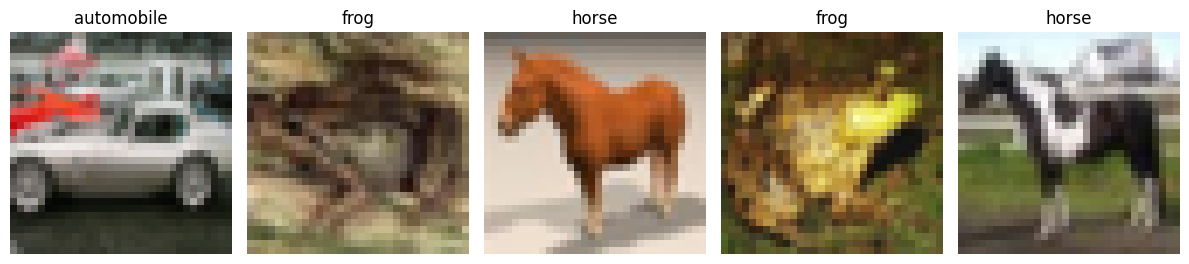


Epoch 1/50
Train Loss: 1.2125, Train Acc: 56.74%, Val Loss: 0.9129, Val Acc: 67.35%
Validation loss decreased (0.912904 --> 0.912904). Saving model...

Epoch 2/50
Train Loss: 0.8556, Train Acc: 70.14%, Val Loss: 1.1849, Val Acc: 60.72%
EarlyStopping counter: 1 out of 10

Epoch 3/50
Train Loss: 0.7062, Train Acc: 75.40%, Val Loss: 0.7362, Val Acc: 74.42%
Validation loss decreased (0.736158 --> 0.736158). Saving model...

Epoch 4/50
Train Loss: 0.5987, Train Acc: 79.23%, Val Loss: 0.9527, Val Acc: 69.35%
EarlyStopping counter: 1 out of 10

Epoch 5/50
Train Loss: 0.5075, Train Acc: 82.19%, Val Loss: 0.6868, Val Acc: 76.77%
Validation loss decreased (0.686842 --> 0.686842). Saving model...

Epoch 6/50
Train Loss: 0.4298, Train Acc: 84.96%, Val Loss: 0.7397, Val Acc: 75.70%
EarlyStopping counter: 1 out of 10

Epoch 7/50
Train Loss: 0.3638, Train Acc: 87.14%, Val Loss: 0.6956, Val Acc: 77.47%
EarlyStopping counter: 2 out of 10

Epoch 8/50
Train Loss: 0.2951, Train Acc: 89.55%, Val Loss: 0.7

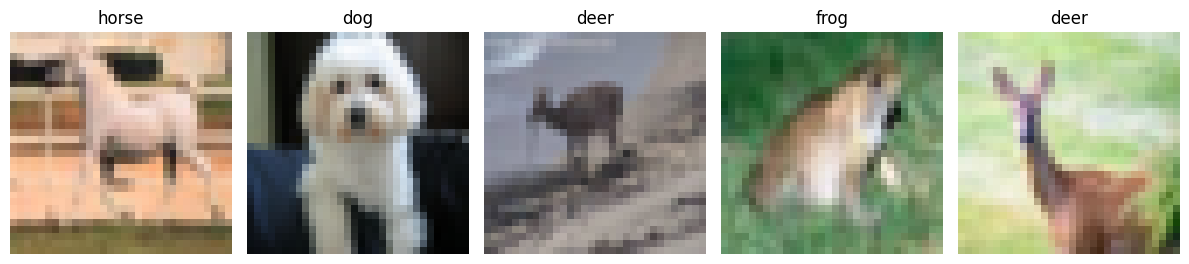


Epoch 1/50
Train Loss: 1.2676, Train Acc: 54.68%, Val Loss: 1.0590, Val Acc: 62.48%
Validation loss decreased (1.059042 --> 1.059042). Saving model...

Epoch 2/50
Train Loss: 0.9514, Train Acc: 66.39%, Val Loss: 0.8866, Val Acc: 69.01%
Validation loss decreased (0.886620 --> 0.886620). Saving model...

Epoch 3/50
Train Loss: 0.8119, Train Acc: 71.49%, Val Loss: 0.8779, Val Acc: 68.67%
Validation loss decreased (0.877921 --> 0.877921). Saving model...

Epoch 4/50
Train Loss: 0.7124, Train Acc: 75.04%, Val Loss: 0.9185, Val Acc: 68.78%
EarlyStopping counter: 1 out of 10

Epoch 5/50
Train Loss: 0.6345, Train Acc: 77.81%, Val Loss: 0.8161, Val Acc: 71.58%
Validation loss decreased (0.816136 --> 0.816136). Saving model...

Epoch 6/50
Train Loss: 0.5675, Train Acc: 80.06%, Val Loss: 0.7553, Val Acc: 73.94%
Validation loss decreased (0.755269 --> 0.755269). Saving model...

Epoch 7/50
Train Loss: 0.5044, Train Acc: 82.28%, Val Loss: 0.8393, Val Acc: 72.72%
EarlyStopping counter: 1 out of 10


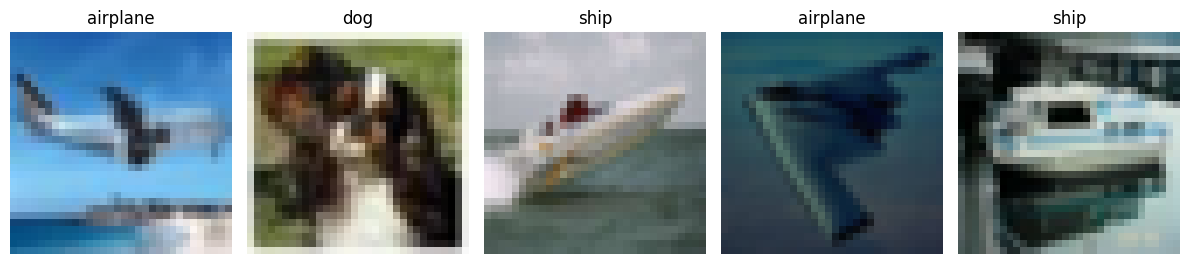


Epoch 1/50
Train Loss: 1.1988, Train Acc: 57.25%, Val Loss: 0.9775, Val Acc: 65.35%
Validation loss decreased (0.977472 --> 0.977472). Saving model...

Epoch 2/50
Train Loss: 0.8533, Train Acc: 70.20%, Val Loss: 0.8030, Val Acc: 72.17%
Validation loss decreased (0.802988 --> 0.802988). Saving model...

Epoch 3/50
Train Loss: 0.7027, Train Acc: 75.31%, Val Loss: 0.7801, Val Acc: 72.56%
Validation loss decreased (0.780075 --> 0.780075). Saving model...

Epoch 4/50
Train Loss: 0.6021, Train Acc: 79.18%, Val Loss: 0.8501, Val Acc: 71.09%
EarlyStopping counter: 1 out of 10

Epoch 5/50
Train Loss: 0.5068, Train Acc: 82.36%, Val Loss: 0.7403, Val Acc: 74.74%
Validation loss decreased (0.740253 --> 0.740253). Saving model...

Epoch 6/50
Train Loss: 0.4290, Train Acc: 85.00%, Val Loss: 0.7528, Val Acc: 74.50%
EarlyStopping counter: 1 out of 10

Epoch 7/50
Train Loss: 0.3551, Train Acc: 87.48%, Val Loss: 0.7234, Val Acc: 76.20%
Validation loss decreased (0.723421 --> 0.723421). Saving model...


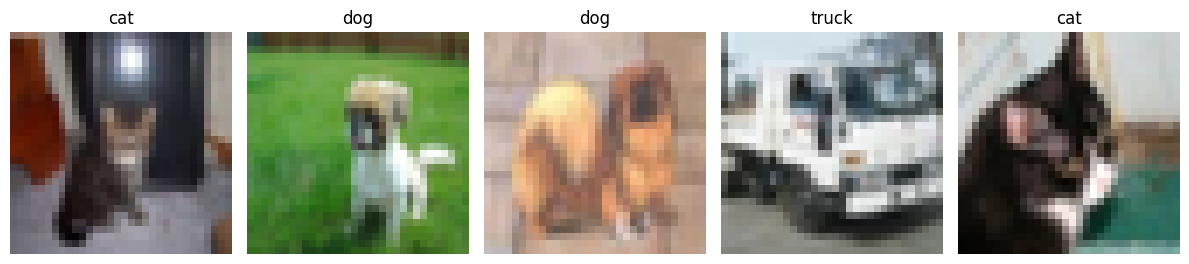


Epoch 1/50
Train Loss: 1.1740, Train Acc: 57.94%, Val Loss: 1.0079, Val Acc: 63.63%
Validation loss decreased (1.007941 --> 1.007941). Saving model...

Epoch 2/50
Train Loss: 0.8170, Train Acc: 71.39%, Val Loss: 0.9997, Val Acc: 64.24%
Validation loss decreased (0.999691 --> 0.999691). Saving model...

Epoch 3/50
Train Loss: 0.6560, Train Acc: 77.17%, Val Loss: 0.7153, Val Acc: 74.80%
Validation loss decreased (0.715313 --> 0.715313). Saving model...

Epoch 4/50
Train Loss: 0.5450, Train Acc: 81.03%, Val Loss: 0.7668, Val Acc: 74.04%
EarlyStopping counter: 1 out of 10

Epoch 5/50
Train Loss: 0.4408, Train Acc: 84.60%, Val Loss: 0.7688, Val Acc: 74.43%
EarlyStopping counter: 2 out of 10

Epoch 6/50
Train Loss: 0.3518, Train Acc: 87.78%, Val Loss: 0.6821, Val Acc: 78.04%
Validation loss decreased (0.682055 --> 0.682055). Saving model...

Epoch 7/50
Train Loss: 0.2842, Train Acc: 90.02%, Val Loss: 0.6408, Val Acc: 79.24%
Validation loss decreased (0.640821 --> 0.640821). Saving model...


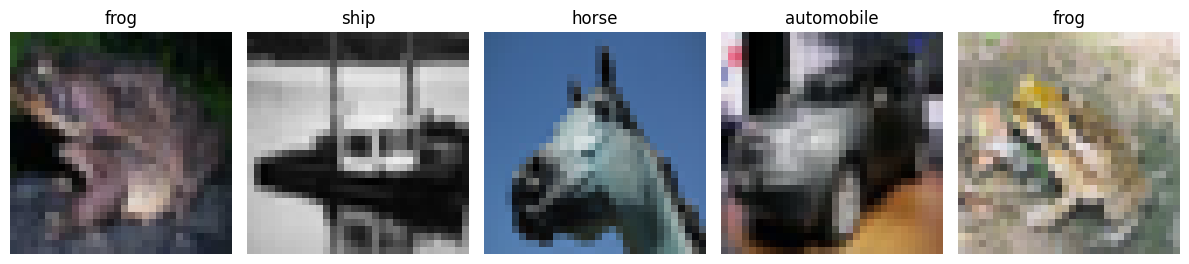


Epoch 1/50
Train Loss: 1.2126, Train Acc: 56.67%, Val Loss: 0.9713, Val Acc: 65.01%
Validation loss decreased (0.971300 --> 0.971300). Saving model...

Epoch 2/50
Train Loss: 0.8720, Train Acc: 69.35%, Val Loss: 0.8721, Val Acc: 69.16%
Validation loss decreased (0.872087 --> 0.872087). Saving model...

Epoch 3/50
Train Loss: 0.7165, Train Acc: 74.86%, Val Loss: 1.0419, Val Acc: 65.36%
EarlyStopping counter: 1 out of 10

Epoch 4/50
Train Loss: 0.6053, Train Acc: 78.88%, Val Loss: 0.7243, Val Acc: 74.47%
Validation loss decreased (0.724274 --> 0.724274). Saving model...

Epoch 5/50
Train Loss: 0.5223, Train Acc: 81.67%, Val Loss: 0.6789, Val Acc: 76.64%
Validation loss decreased (0.678928 --> 0.678928). Saving model...

Epoch 6/50
Train Loss: 0.4403, Train Acc: 84.50%, Val Loss: 0.7377, Val Acc: 75.04%
EarlyStopping counter: 1 out of 10

Epoch 7/50
Train Loss: 0.3734, Train Acc: 87.08%, Val Loss: 0.8401, Val Acc: 74.10%
EarlyStopping counter: 2 out of 10

Epoch 8/50
Train Loss: 0.3202, 

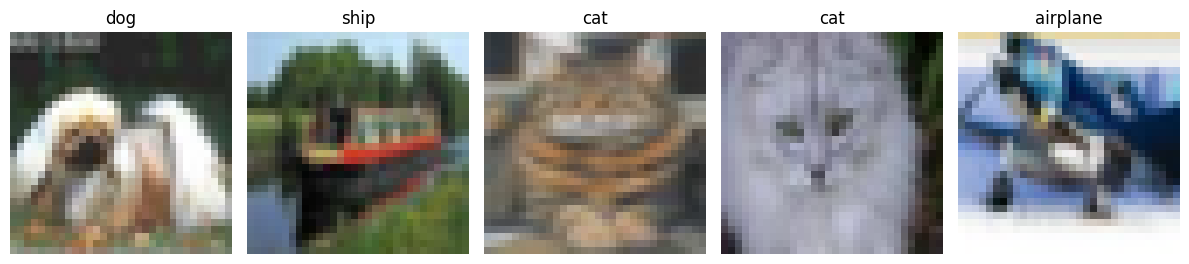


Epoch 1/50
Train Loss: 1.2919, Train Acc: 53.48%, Val Loss: 1.1079, Val Acc: 59.91%
Validation loss decreased (1.107882 --> 1.107882). Saving model...

Epoch 2/50
Train Loss: 0.9013, Train Acc: 68.63%, Val Loss: 0.9137, Val Acc: 68.58%
Validation loss decreased (0.913686 --> 0.913686). Saving model...

Epoch 3/50
Train Loss: 0.7411, Train Acc: 74.34%, Val Loss: 0.8944, Val Acc: 69.32%
Validation loss decreased (0.894392 --> 0.894392). Saving model...

Epoch 4/50
Train Loss: 0.6270, Train Acc: 78.45%, Val Loss: 0.9447, Val Acc: 69.48%
EarlyStopping counter: 1 out of 10

Epoch 5/50
Train Loss: 0.5334, Train Acc: 81.65%, Val Loss: 0.7559, Val Acc: 74.07%
Validation loss decreased (0.755884 --> 0.755884). Saving model...

Epoch 6/50
Train Loss: 0.4565, Train Acc: 84.35%, Val Loss: 0.8413, Val Acc: 72.47%
EarlyStopping counter: 1 out of 10

Epoch 7/50
Train Loss: 0.3865, Train Acc: 86.66%, Val Loss: 0.7936, Val Acc: 74.72%
EarlyStopping counter: 2 out of 10

Epoch 8/50
Train Loss: 0.3256, 

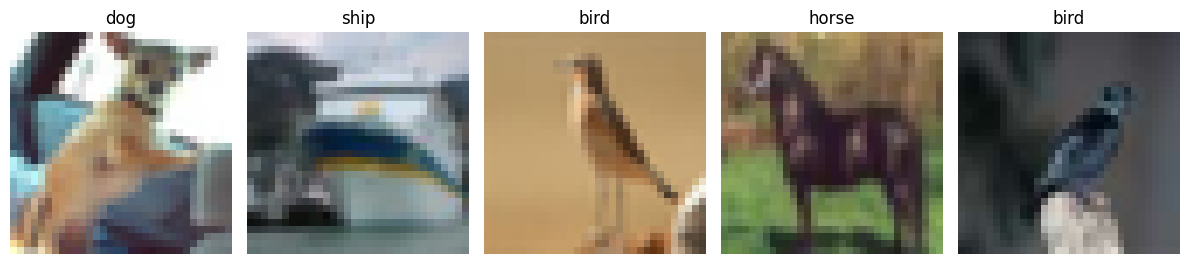

/home/hashim/miniconda3/envs/gena1/lib/python3.12/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")



Epoch 1/50


RuntimeError: Given input size: (1024x1x1). Calculated output size: (1024x0x0). Output size is too small

In [17]:
if __name__ == '__main__':
    # Set device: GPU if available, otherwise CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Using device:", device)
    
    experiments = []
    
    # -----------------------------
    # 1. Hyperparameter Tuning: Learning Rate
    # -----------------------------
    learning_rates = [0.001, 0.01, 0.1]
    for lr in learning_rates:
        experiment_name = f"LR={lr}"
        print(f"\nRunning experiment: {experiment_name}")
        
        # Use default batch size, filters, and layers for this experiment
        train_loader, val_loader, test_loader, class_names = prepare_cifar10_dataset(batch_size=64)
        model = CIFAR10CNN(num_filters=32, num_conv_layers=3, dropout_rate=0.3).to(device)
        
        start_time = time.time()
        history, best_val_acc = train_model(model, train_loader, val_loader, test_loader,
                                              learning_rate=lr, epochs=50, device=device)
        training_time = time.time() - start_time
        
        test_acc, _ = test(model, test_loader, device)
        
        experiments.append({
            "name": experiment_name,
            "best_val_accuracy": best_val_acc,
            "test_accuracy": test_acc,
            "training_time": training_time
        })
    
    # -----------------------------
    # 2. Hyperparameter Tuning: Batch Size
    # -----------------------------
    batch_sizes = [16, 32, 64]
    for bs in batch_sizes:
        experiment_name = f"Batch={bs}"
        print(f"\nRunning experiment: {experiment_name}")
        
        train_loader, val_loader, test_loader, class_names = prepare_cifar10_dataset(batch_size=bs)
        model = CIFAR10CNN(num_filters=32, num_conv_layers=3, dropout_rate=0.3).to(device)
        
        start_time = time.time()
        history, best_val_acc = train_model(model, train_loader, val_loader, test_loader,
                                              learning_rate=0.001, epochs=50, device=device)
        training_time = time.time() - start_time
        
        test_acc, _ = test(model, test_loader, device)
        
        experiments.append({
            "name": experiment_name,
            "best_val_accuracy": best_val_acc,
            "test_accuracy": test_acc,
            "training_time": training_time
        })
    
    # -----------------------------
    # 3. Hyperparameter Tuning: Number of Convolutional Filters
    # -----------------------------
    filter_list = [16, 32, 64]
    for nf in filter_list:
        experiment_name = f"Filters={nf}"
        print(f"\nRunning experiment: {experiment_name}")
        
        train_loader, val_loader, test_loader, class_names = prepare_cifar10_dataset(batch_size=64)
        model = CIFAR10CNN(num_filters=nf, num_conv_layers=3, dropout_rate=0.3).to(device)
        
        start_time = time.time()
        history, best_val_acc = train_model(model, train_loader, val_loader, test_loader,
                                              learning_rate=0.001, epochs=50, device=device)
        training_time = time.time() - start_time
        
        test_acc, _ = test(model, test_loader, device)
        
        experiments.append({
            "name": experiment_name,
            "best_val_accuracy": best_val_acc,
            "test_accuracy": test_acc,
            "training_time": training_time
        })
    
    # -----------------------------
    # 4. Hyperparameter Tuning: Number of Convolutional Layers
    # -----------------------------
    layer_list = [3, 5, 7]
    for nl in layer_list:
        experiment_name = f"Layers={nl}"
        print(f"\nRunning experiment: {experiment_name}")
        
        train_loader, val_loader, test_loader, class_names = prepare_cifar10_dataset(batch_size=64)
        model = CIFAR10CNN(num_filters=32, num_conv_layers=nl, dropout_rate=0.3).to(device)
        
        start_time = time.time()
        history, best_val_acc = train_model(model, train_loader, val_loader, test_loader,
                                              learning_rate=0.001, epochs=50, device=device)
        training_time = time.time() - start_time
        
        test_acc, _ = test(model, test_loader, device)
        
        experiments.append({
            "name": experiment_name,
            "best_val_accuracy": best_val_acc,
            "test_accuracy": test_acc,
            "training_time": training_time
        })
    
    # -----------------------------
    # Visualize and Compare Experiment Results
    # -----------------------------
    plot_comparative_results(experiments)


In [38]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from datasets import load_dataset
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torchsummary import summary
import math
import pandas as pd  # For creating a results table

# --------------------------
# Dataset Preparation Function with Augmentation Option
# --------------------------
def prepare_cifar10_dataset(batch_size=64, augment=False):
    print("Loading CIFAR-10 dataset from Hugging Face...")
    dataset = load_dataset("cifar10")
    
    # Extract train and test sets
    train_dataset = dataset['train']
    test_dataset = dataset['test']
    
    # Convert to numpy arrays
    X_train = np.array([np.array(image) for image in train_dataset['img']])
    y_train = np.array(train_dataset['label'])
    X_test = np.array([np.array(image) for image in test_dataset['img']])
    y_test = np.array(test_dataset['label'])
    
    print(f"Original dataset shapes:")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
    
    if augment:
        train_transform = transforms.Compose([
            transforms.ToPILImage(),                # Convert NumPy array to PIL Image
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.RandomAffine(0, translate=(0.1, 0.1)),
            transforms.ToTensor()                   # Convert back to tensor
        ])
    else:
        train_transform = transforms.Compose([
            transforms.ToPILImage(),                # Convert NumPy array to PIL Image
            transforms.ToTensor()
        ])

        
    test_transform = transforms.ToTensor()
    
    # Create custom datasets
    train_data = CIFAR10Dataset(X_train, y_train, transform=train_transform)
    test_data = CIFAR10Dataset(X_test, y_test, transform=test_transform)
    
    # Split training data into train and validation sets (80% train, 20% validation)
    train_size = int(0.8 * len(train_data))
    val_size = len(train_data) - train_size
    train_dataset, val_dataset = random_split(train_data, [train_size, val_size],
                                              generator=torch.Generator().manual_seed(42))
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_data, batch_size=batch_size)
    
    # Define class names for reference
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']
    
    return train_loader, val_loader, test_loader, class_names

# --------------------------
# Custom Dataset Class
# --------------------------
class CIFAR10Dataset(Dataset):
    """Custom PyTorch Dataset for CIFAR-10"""
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.targets[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# --------------------------
# Model Definition
# --------------------------
class CIFAR10CNN(nn.Module):
    def __init__(self, num_filters=32, num_conv_layers=3, dropout_rate=0.3):
        super(CIFAR10CNN, self).__init__()
        self.num_conv_layers = num_conv_layers
        
        # First convolutional block
        self.conv_layers = nn.ModuleList()
        self.conv_layers.append(nn.Conv2d(3, num_filters, kernel_size=3, padding=1))
        self.batch_norms = nn.ModuleList()
        self.batch_norms.append(nn.BatchNorm2d(num_filters))
        
        # Additional convolutional blocks
        for i in range(1, num_conv_layers):
            in_channels = num_filters * (2**(i-1))
            out_channels = num_filters * (2**i)
            self.conv_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            self.batch_norms.append(nn.BatchNorm2d(out_channels))
        
        # Calculate final feature map size after conv layers with pooling (using ceil to avoid 0)
        final_size = math.ceil(32 / (2**num_conv_layers))
        final_channels = num_filters * (2**(num_conv_layers-1))
        
        # Fully connected layers
        self.fc1 = nn.Linear(final_channels * final_size * final_size, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        for i in range(self.num_conv_layers):
            x = self.conv_layers[i](x)
            x = self.batch_norms[i](x)
            x = F.relu(x)
            x = F.max_pool2d(x, 2, ceil_mode=True)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn_fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

# --------------------------
# Training, Validation, Testing Functions
# --------------------------
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
    return running_loss / len(train_loader), 100. * correct / total

def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    return val_loss / len(val_loader), 100. * correct / total

def test(model, test_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    return 100. * correct / total

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.verbose = verbose
        
    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.best_score:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), 'checkpoint.pt')

def train_model(model, train_loader, val_loader, test_loader, learning_rate=0.001, epochs=50, device='cuda'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)
    early_stopping = EarlyStopping(patience=10, verbose=True)
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_acc = 0
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        scheduler.step(val_loss)
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        best_val_acc = max(best_val_acc, val_acc)
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
    return history, best_val_acc

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds = output.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    all_preds, all_targets = np.array(all_preds), np.array(all_targets)
    acc = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='weighted')
    recall = recall_score(all_targets, all_preds, average='weighted')
    f1 = f1_score(all_targets, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_targets, all_preds)
    return acc, precision, recall, f1, conf_matrix

# --------------------------
# Main Experiment: Comparing Without vs With Data Augmentation
# --------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Model without augmentation
print("\nTraining model WITHOUT data augmentation")
train_loader, val_loader, test_loader, class_names = prepare_cifar10_dataset(batch_size=64, augment=False)
model_without = CIFAR10CNN(num_filters=32, num_conv_layers=3, dropout_rate=0.3).to(device)
history_without, best_val_acc_without = train_model(model_without, train_loader, val_loader, test_loader,
                                                      learning_rate=0.001, epochs=50, device=device)
acc_wo, precision_wo, recall_wo, f1_wo, conf_matrix_wo = evaluate_model(model_without, test_loader, device)

# Model with augmentation
print("\nTraining model WITH data augmentation")
train_loader_aug, val_loader_aug, test_loader_aug, class_names = prepare_cifar10_dataset(batch_size=64, augment=True)
model_with = CIFAR10CNN(num_filters=32, num_conv_layers=3, dropout_rate=0.3).to(device)
history_with, best_val_acc_with = train_model(model_with, train_loader_aug, val_loader_aug, test_loader_aug,
                                                learning_rate=0.001, epochs=50, device=device)
acc_aug, precision_aug, recall_aug, f1_aug, conf_matrix_aug = evaluate_model(model_with, test_loader_aug, device)

# --------------------------
# Present the Results in a Table
# --------------------------
results = [
    {
        "Model": "Without Augmentation",
        "Accuracy": f"{acc_wo*100:.2f}%",
        "Precision": f"{precision_wo*100:.2f}%",
        "Recall": f"{recall_wo*100:.2f}%",
        "F1-Score": f"{f1_wo*100:.2f}%"
    },
    {
        "Model": "With Augmentation",
        "Accuracy": f"{acc_aug*100:.2f}%",
        "Precision": f"{precision_aug*100:.2f}%",
        "Recall": f"{recall_aug*100:.2f}%",
        "F1-Score": f"{f1_aug*100:.2f}%"
    }
]

df_results = pd.DataFrame(results)
print("\nTable 1: Performance Metrics Comparison of CNN Models")
print(df_results.to_markdown(index=False))


Using device: cuda

Training model WITHOUT data augmentation
Loading CIFAR-10 dataset from Hugging Face...
Original dataset shapes:
X_train: (50000, 32, 32, 3), y_train: (50000,)
X_test: (10000, 32, 32, 3), y_test: (10000,)

Epoch 1/50


/home/hashim/miniconda3/envs/gena1/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Loss: 1.1779, Train Acc: 57.88%, Val Loss: 1.1811, Val Acc: 58.91%
Validation loss decreased (1.181123 --> 1.181123). Saving model...

Epoch 2/50
Train Loss: 0.8460, Train Acc: 70.39%, Val Loss: 1.2984, Val Acc: 57.40%
EarlyStopping counter: 1 out of 10

Epoch 3/50
Train Loss: 0.6935, Train Acc: 75.53%, Val Loss: 0.8682, Val Acc: 70.58%
Validation loss decreased (0.868151 --> 0.868151). Saving model...

Epoch 4/50
Train Loss: 0.5869, Train Acc: 79.20%, Val Loss: 0.8887, Val Acc: 70.11%
EarlyStopping counter: 1 out of 10

Epoch 5/50
Train Loss: 0.4991, Train Acc: 82.47%, Val Loss: 0.7461, Val Acc: 74.63%
Validation loss decreased (0.746066 --> 0.746066). Saving model...

Epoch 6/50
Train Loss: 0.4186, Train Acc: 85.25%, Val Loss: 0.6788, Val Acc: 77.13%
Validation loss decreased (0.678769 --> 0.678769). Saving model...

Epoch 7/50
Train Loss: 0.3515, Train Acc: 87.56%, Val Loss: 0.7301, Val Acc: 76.87%
EarlyStopping counter: 1 out of 10

Epoch 8/50
Train Loss: 0.2939, Train Acc: 8

/home/hashim/miniconda3/envs/gena1/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Loss: 1.3838, Train Acc: 49.85%, Val Loss: 1.2916, Val Acc: 54.14%
Validation loss decreased (1.291626 --> 1.291626). Saving model...

Epoch 2/50
Train Loss: 1.0686, Train Acc: 62.05%, Val Loss: 1.2298, Val Acc: 57.04%
Validation loss decreased (1.229800 --> 1.229800). Saving model...

Epoch 3/50
Train Loss: 0.9451, Train Acc: 66.44%, Val Loss: 0.9814, Val Acc: 65.69%
Validation loss decreased (0.981368 --> 0.981368). Saving model...

Epoch 4/50
Train Loss: 0.8707, Train Acc: 69.22%, Val Loss: 0.8870, Val Acc: 68.10%
Validation loss decreased (0.887019 --> 0.887019). Saving model...

Epoch 5/50
Train Loss: 0.8229, Train Acc: 71.07%, Val Loss: 0.7994, Val Acc: 71.45%
Validation loss decreased (0.799350 --> 0.799350). Saving model...

Epoch 6/50
Train Loss: 0.7819, Train Acc: 72.57%, Val Loss: 0.7253, Val Acc: 74.29%
Validation loss decreased (0.725267 --> 0.725267). Saving model...

Epoch 7/50
Train Loss: 0.7426, Train Acc: 74.08%, Val Loss: 0.7833, Val Acc: 72.62%
EarlyStopping c